<a href="https://colab.research.google.com/github/nainye/nlp_practice/blob/main/language_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 8.1MB/s 


# Evn

In [2]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [3]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
!nvidia-smi

Wed Feb 24 07:00:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data dir
data_dir = '/content/drive/MyDrive/AI집중캠프(자연어처리)/실습/data'
os.listdir(data_dir)

['ko_32000.model', 'ko_32000.vocab', 'kowiki', 'nsmc', 'quora', 'songys']

In [7]:
# korean wiki dir
kowiki_dir = os.path.join(data_dir, 'kowiki')
if not os.path.exists(kowiki_dir):
    os.makedirs(kowiki_dir)
os.listdir(kowiki_dir)

['kowiki.txt.zip',
 'my_corpus.txt',
 'kowiki_lm.json.zip',
 'kowiki_lm.json',
 'lm.hdf5',
 'lm.csv']

# Vocabulary & config

In [8]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [9]:
n_vocab = len(vocab)  # number of vocabulary
n_seq = 256  # number of sequence
d_model = 256  # dimension of model

# 모델링

In [10]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아 나는 오늘 우울해',
    '나는 오늘 행복해 나는 오늘 즐거워'
]

In [11]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[BOS]': 2,
  '[EOS]': 3,
  '[PAD]': 0,
  '[UNK]': 1,
  '기분이': 6,
  '나는': 4,
  '오늘': 5,
  '우울해': 8,
  '좋아': 7,
  '즐거워': 10,
  '행복해': 9},
 {0: '[PAD]',
  1: '[UNK]',
  2: '[BOS]',
  3: '[EOS]',
  4: '나는',
  5: '오늘',
  6: '기분이',
  7: '좋아',
  8: '우울해',
  9: '행복해',
  10: '즐거워'})

In [12]:
# 학습용 입력 데이터 생성
train_ids = []
for sentence in sentences:
    train_ids.append([word_to_id[word] for word in sentence.split()])

# id를 입력과 정답으로 저장
train_inputs, train_labels = [], []
for train_id in train_ids:
    train_inputs.append([word_to_id['[BOS]']] + train_id)
    train_labels.append(train_id + [word_to_id['[EOS]']])

# 문장의 길이를 모두 동일하게 변경 (최대길이 8)
for row in train_inputs:
    row += [0] * (8 - len(row))

# 문장의 길이를 모두 동일하게 변경 (최대길이 8)
for row in train_labels:
    row += [0] * (8 - len(row))

# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)
train_labels = np.array(train_labels)

train_inputs, train_labels

(array([[ 2,  4,  5,  6,  7,  4,  5,  8],
        [ 2,  4,  5,  9,  4,  5, 10,  0]]),
 array([[ 4,  5,  6,  7,  4,  5,  8,  3],
        [ 4,  5,  9,  4,  5, 10,  3,  0]]))

In [13]:
# 단어를 벡터로 변환
embedding = tf.keras.layers.Embedding(len(word_to_id), 4)
hidden = embedding(train_inputs)  # (bs, n_seq, 4)
hidden

<tf.Tensor: shape=(2, 8, 4), dtype=float32, numpy=
array([[[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [-0.00963336, -0.01013004,  0.01826939,  0.02741292],
        [-0.00544795, -0.04431503, -0.02540476, -0.0194685 ],
        [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [-0.01826397, -0.03069841,  0.03251565,  0.00923193]],

       [[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [-0.01256046,  0.0343336 , -0.02595751,  0.03221213],
        [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [-0.03375109, -0.02327753, -0.00871272,  0.00912046],
        [ 0.00380

In [14]:
# LSTM 실행
lstm = tf.keras.layers.LSTM(units=5, return_sequences=True)
hidden = lstm(hidden)
hidden

<tf.Tensor: shape=(2, 8, 5), dtype=float32, numpy=
array([[[ 0.00319188,  0.0004601 ,  0.00048046,  0.00068459,
          0.00486466],
        [ 0.00894166, -0.00398243, -0.00042938, -0.00316281,
          0.01105411],
        [ 0.00766935, -0.00386156,  0.00388169, -0.00665173,
          0.00903312],
        [ 0.00829616, -0.00536775,  0.00688199, -0.01092444,
          0.01057143],
        [-0.00012326, -0.00511966, -0.00149244, -0.00613498,
         -0.0010604 ],
        [ 0.00606216, -0.00820581, -0.00172402, -0.00856205,
          0.00738286],
        [ 0.00519836, -0.00702938,  0.00313166, -0.01096036,
          0.00693066],
        [ 0.00657915, -0.00800196,  0.00457055, -0.01407604,
          0.00739967]],

       [[ 0.00319188,  0.0004601 ,  0.00048046,  0.00068459,
          0.00486466],
        [ 0.00894166, -0.00398243, -0.00042938, -0.00316281,
          0.01105411],
        [ 0.00766935, -0.00386156,  0.00388169, -0.00665173,
          0.00903312],
        [ 0.00388655, -

In [15]:
# 다음단어 예측
dense = tf.keras.layers.Dense(len(word_to_id), activation=tf.nn.softmax)
outputs = dense(hidden)
outputs

<tf.Tensor: shape=(2, 8, 11), dtype=float32, numpy=
array([[[0.09095009, 0.09100534, 0.09078809, 0.09107333, 0.09073468,
         0.09084196, 0.09071952, 0.0911459 , 0.09077941, 0.09089004,
         0.09107161],
        [0.09091932, 0.0908605 , 0.09085783, 0.09155371, 0.09053011,
         0.09105469, 0.09082662, 0.09110866, 0.0907365 , 0.09049691,
         0.09105515],
        [0.0910784 , 0.09098901, 0.09074864, 0.09155462, 0.090539  ,
         0.09118763, 0.09117985, 0.09108083, 0.09056233, 0.09015973,
         0.09091996],
        [0.09113628, 0.09101795, 0.09070639, 0.09178611, 0.09049145,
         0.09136044, 0.0914659 , 0.09108679, 0.0903735 , 0.08977969,
         0.0907955 ],
        [0.09075198, 0.09058631, 0.09120022, 0.09120046, 0.09101953,
         0.09125873, 0.09135398, 0.0905164 , 0.0910138 , 0.09051464,
         0.09058393],
        [0.09073099, 0.09053629, 0.0911767 , 0.09170382, 0.09075757,
         0.09136692, 0.09129173, 0.09067336, 0.09086999, 0.09021923,
         0

In [16]:
def build_model(n_vocab, d_model, n_seq):
    """
    문장 유사도 비교 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장 길이 (단어 수)
    """
    inputs = tf.keras.layers.Input((n_seq,))  # (bs, n_seq)
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden = embedding(inputs)  # (bs, n_seq, d_model)
    # LSTM
    lstm = tf.keras.layers.LSTM(units=d_model * 2, return_sequences=True)
    hidden = lstm(hidden)  # (bs, n_seq, d_model * 2)
    # 다음단어 확률 분포
    dense = tf.keras.layers.Dense(n_vocab, activation=tf.nn.softmax)
    outputs = dense(hidden)
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

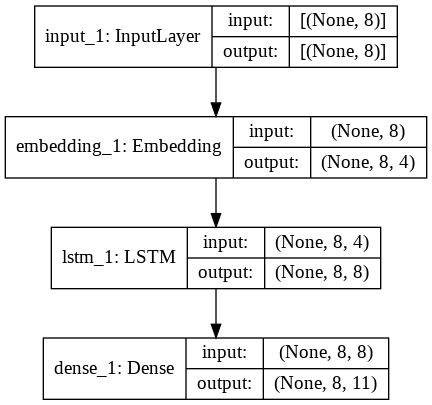

In [17]:
# 모델 생성
model = build_model(len(word_to_id), 4, 8)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

# Preprocessing


In [18]:
# 파일 내용 확인
with zipfile.ZipFile(os.path.join(kowiki_dir, 'kowiki.txt.zip')) as z:
    with z.open('kowiki.txt') as f:
        for i, line in enumerate(f):
            line = line.decode('utf-8').strip()
            print(line)
            if i >= 100:
                break

지미 카터
제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39대 대통령 (1977년 ~ 1981년)이다.
지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.
1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.
1976년 미합중국 (미국) 제39대 대통령 선거에 민주당 후보로 출마하여 도덕주의 정책으로 내세워서, 많은 지지를 받고 제럴드 포드 (당시 미국 대통령) 를 누르고 당선되었다.
카터 대통령은 에너지 개발을 촉구했으나 공화당의 반대로 무산되었다.
카터는 이집트와 이스라엘을 조정하여, 캠프 데이비드에서 안와르 사다트 대통령과 메나헴 베긴 수상과 함께 중동 평화를 위한 캠프데이비드 협정을 체결했다.
그러나 이것은 공화당과 미국의 유대인 단체의 반발을 일으켰다. 1979년 백악관에서 양국 간의 평화조약으로 이끌어졌다. 또한 소련과 제2차 전략 무기 제한 협상에 조인했다.
카터는 1970년대 후반 당시 대한민국 등 인권 후진국의 국민들의 인권을 지키기 위해 노력했으며, 취임 이후 계속해서 도덕정치를 내세웠다.
그러나 주 이란 미국 대사관 인질 사건에서 인질 구출 실패를 이유로 1980년 대통령 선거에서 공화당의 로널드 레이건 후보에게 져 결국 재선에 실패했다. 또한 임기 말기에 터진 소련의 아프가니스탄 침공 사건으로 인해 1980년 하계 올림픽에 반공국가들의 보이콧

In [19]:
# 파일 내용 확인 (주제단위)
with zipfile.ZipFile(os.path.join(kowiki_dir, 'kowiki.txt.zip')) as z:
    with z.open('kowiki.txt') as f:
        doc = []
        for i, line in enumerate(f):
            line = line.decode('utf-8').strip()
            if len(line) == 0:
                if len(doc) > 0:
                    break
            else:
                doc.append(line)
doc

['지미 카터',
 '제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39대 대통령 (1977년 ~ 1981년)이다.',
 '지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.',
 '1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.',
 '1976년 미합중국 (미국) 제39대 대통령 선거에 민주당 후보로 출마하여 도덕주의 정책으로 내세워서, 많은 지지를 받고 제럴드 포드 (당시 미국 대통령) 를 누르고 당선되었다.',
 '카터 대통령은 에너지 개발을 촉구했으나 공화당의 반대로 무산되었다.',
 '카터는 이집트와 이스라엘을 조정하여, 캠프 데이비드에서 안와르 사다트 대통령과 메나헴 베긴 수상과 함께 중동 평화를 위한 캠프데이비드 협정을 체결했다.',
 '그러나 이것은 공화당과 미국의 유대인 단체의 반발을 일으켰다. 1979년 백악관에서 양국 간의 평화조약으로 이끌어졌다. 또한 소련과 제2차 전략 무기 제한 협상에 조인했다.',
 '카터는 1970년대 후반 당시 대한민국 등 인권 후진국의 국민들의 인권을 지키기 위해 노력했으며, 취임 이후 계속해서 도덕정치를 내세웠다.',
 '그러나 주 이란 미국 대사관 인질 사건에서 인질 구출 실패를 이유로 1980년 대통령 선거에서 공화당의 로널드 레이건 후보에게 져 결국 재선에 실패했다. 또한 임기 말기에 터진 소련의 아프가니

In [20]:
def create_train_instance(vocab, n_seq, doc):
    """
    create train instance
    :param vocab: vocabulary object
    :param n_seq: sequece number
    :param doc: wiki document
    :return: train instance list
    """
    n_max = n_seq - 1
    instance_list = []

    chunk = []
    chunk_len = 0
    for i, line in enumerate(doc):
        tokens = vocab.encode_as_pieces(line)
        chunk.append(tokens)
        chunk_len += len(tokens)
        if n_max <= chunk_len or i >= len(doc) -1:
            # print()
            # print(chunk_len, chunk)
            instance = []
            for tokens in chunk:
                instance.extend(tokens)
            # print(len(instance), instance)
            instance = instance[:n_max]
            # print(len(instance), instance)
            instance_list.append(instance)
            chunk = []
            chunk_len = 0

    return instance_list

In [21]:
# instance 동작 확인
instance_list = create_train_instance(vocab, n_seq, doc)
for instance in instance_list:
    print(len(instance), instance)

255 ['▁지미', '▁카터', '▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카터', '▁주니어', '(', ',', '▁1924', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '▁출신', '▁미국', '▁39', '대', '▁대통령', '▁', '(1977', '년', '▁~', '▁1981', '년', ')', '이다', '.', '▁지미', '▁카터', '는', '▁조지아주', '▁섬', '터', '▁카운티', '▁플레', '인', '스', '▁마을에서', '▁태어났다', '.', '▁조지아', '▁공과대학교', '를', '▁졸업하였다', '.', '▁그', '▁후', '▁해군', '에', '▁들어가', '▁전함', '·', '원자력', '·', '잠수함', '의', '▁승무원', '으로', '▁일', '하였다', '.', '▁1953', '년', '▁미국', '▁해군', '▁대위', '로', '▁예편', '하였고', '▁이후', '▁땅콩', '·', '면', '화', '▁등을', '▁가', '꿔', '▁많은', '▁돈을', '▁벌', '었다', '.', '▁그의', '▁별명이', '▁"', '땅', '콩', '▁농부', '"', '▁(', 'P', 'ean', 'ut', '▁F', 'ar', 'mer', ')', '로', '▁알려졌다', '.', '▁1962', '년', '▁조지아', '▁주', '▁상원', '▁의원', '▁선거에서', '▁낙선', '하나', '▁그', '▁선거', '가', '▁부정', '선거', '▁', '였', '음을', '▁입증', '하게', '▁되어', '▁당선', '되고', ',', '▁1966', '년', '▁조지아', '▁주', '▁지사', '▁선거에', '▁낙선', '하지만', '▁1970', '년', '▁조지아', '▁주', '▁지사', '를', '▁역임했다', '.', '▁대통령이', '▁되기', '▁전', '▁조지아주', '▁상원의원', '을'

In [22]:
# instance를 json 형태로 저장하는 함수
def save_instance(vocab, n_seq, doc, o_f):
    instance_list = create_train_instance(vocab, n_seq, doc)
    for instance in instance_list:
        o_f.write(json.dumps({'token': instance}, ensure_ascii=False))
        o_f.write('\n')

In [23]:
# 전체 문서에 대한 instance 생성
with open(os.path.join(kowiki_dir, 'kowiki_lm.json'), 'w') as o_f:
    with zipfile.ZipFile(os.path.join(kowiki_dir, 'kowiki.txt.zip')) as z:
        with z.open('kowiki.txt') as f:
            doc = []
            for i, line in enumerate(tqdm(f)):
                line = line.decode('utf-8').strip()
                if len(line) == 0:
                    if len(doc) > 0:
                        save_instance(vocab, n_seq, doc, o_f)
                        doc = []
                else:
                    doc.append(line)
            if len(doc) > 0:
                save_instance(vocab, n_seq, doc, o_f)

In [24]:
# 파일 라인수 확인
n_line = 0
with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
    for line in f:
        n_line += 1
        if n_line <= 10:
            print(line)
n_line

{"token": ["▁지미", "▁카터", "▁제임스", "▁얼", "▁\"", "지", "미", "\"", "▁카터", "▁주니어", "(", ",", "▁1924", "년", "▁10", "월", "▁1", "일", "▁~", "▁)", "는", "▁민주당", "▁출신", "▁미국", "▁39", "대", "▁대통령", "▁", "(1977", "년", "▁~", "▁1981", "년", ")", "이다", ".", "▁지미", "▁카터", "는", "▁조지아주", "▁섬", "터", "▁카운티", "▁플레", "인", "스", "▁마을에서", "▁태어났다", ".", "▁조지아", "▁공과대학교", "를", "▁졸업하였다", ".", "▁그", "▁후", "▁해군", "에", "▁들어가", "▁전함", "·", "원자력", "·", "잠수함", "의", "▁승무원", "으로", "▁일", "하였다", ".", "▁1953", "년", "▁미국", "▁해군", "▁대위", "로", "▁예편", "하였고", "▁이후", "▁땅콩", "·", "면", "화", "▁등을", "▁가", "꿔", "▁많은", "▁돈을", "▁벌", "었다", ".", "▁그의", "▁별명이", "▁\"", "땅", "콩", "▁농부", "\"", "▁(", "P", "ean", "ut", "▁F", "ar", "mer", ")", "로", "▁알려졌다", ".", "▁1962", "년", "▁조지아", "▁주", "▁상원", "▁의원", "▁선거에서", "▁낙선", "하나", "▁그", "▁선거", "가", "▁부정", "선거", "▁", "였", "음을", "▁입증", "하게", "▁되어", "▁당선", "되고", ",", "▁1966", "년", "▁조지아", "▁주", "▁지사", "▁선거에", "▁낙선", "하지만", "▁1970", "년", "▁조지아", "▁주", "▁지사", "를", "▁역임했다", ".", "▁대통령이", "▁되기", "▁전", "▁조지아주", "▁

778381

# Sample Data Project

## Data


In [25]:
def load_data(vocab, n_seq):
    """
    Language Model 학습 데이터 생성
    :param vocab: vocabulary object
    :param n_seq: number of sequence
    :return inputs_1: input data 1
    :return inputs_2: input data 2
    :return labels: label data
    """
    # line 수 조회
    # n_line = 0
    # with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
    #     for line in f:
    #         n_line += 1
    # 10개로 제한
    n_data = 10
    # 빈 데이터 생성
    inputs = np.zeros((n_data, n_seq)).astype(np.int32)
    labels = np.zeros((n_data, n_seq)).astype(np.int32)

    with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
        for i, line in enumerate(f):
            if i >= n_data:
                break
            data = json.loads(line)
            print()
            print(data)
            token_id = [vocab.piece_to_id(p) for p in data['token']]
            print(len(token_id), token_id)
            # input id
            input_id = [vocab.bos_id()] + token_id
            input_id += [0] * (n_seq - len(input_id))
            print(len(input_id), input_id)
            # label id
            label_id = token_id + [vocab.eos_id()]
            label_id += [0] * (n_seq - len(label_id))
            print(len(label_id), label_id)
            # 값 저장
            inputs[i] = input_id
            labels[i] = label_id

    return inputs, labels

In [26]:
# train data 생성
train_inputs, train_labels = load_data(vocab, n_seq)
train_inputs, train_labels


{'token': ['▁지미', '▁카터', '▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카터', '▁주니어', '(', ',', '▁1924', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '▁출신', '▁미국', '▁39', '대', '▁대통령', '▁', '(1977', '년', '▁~', '▁1981', '년', ')', '이다', '.', '▁지미', '▁카터', '는', '▁조지아주', '▁섬', '터', '▁카운티', '▁플레', '인', '스', '▁마을에서', '▁태어났다', '.', '▁조지아', '▁공과대학교', '를', '▁졸업하였다', '.', '▁그', '▁후', '▁해군', '에', '▁들어가', '▁전함', '·', '원자력', '·', '잠수함', '의', '▁승무원', '으로', '▁일', '하였다', '.', '▁1953', '년', '▁미국', '▁해군', '▁대위', '로', '▁예편', '하였고', '▁이후', '▁땅콩', '·', '면', '화', '▁등을', '▁가', '꿔', '▁많은', '▁돈을', '▁벌', '었다', '.', '▁그의', '▁별명이', '▁"', '땅', '콩', '▁농부', '"', '▁(', 'P', 'ean', 'ut', '▁F', 'ar', 'mer', ')', '로', '▁알려졌다', '.', '▁1962', '년', '▁조지아', '▁주', '▁상원', '▁의원', '▁선거에서', '▁낙선', '하나', '▁그', '▁선거', '가', '▁부정', '선거', '▁', '였', '음을', '▁입증', '하게', '▁되어', '▁당선', '되고', ',', '▁1966', '년', '▁조지아', '▁주', '▁지사', '▁선거에', '▁낙선', '하지만', '▁1970', '년', '▁조지아', '▁주', '▁지사', '를', '▁역임했다', '.', '▁대통령이', '▁되기', '▁전', '▁조지아주', '▁상원의

(array([[    2, 14473, 14639, ...,    24,   112,  6087],
        [    2,   138,   931, ...,   167,  8945,    59],
        [    2, 12780,    82, ...,    16,  2194,    43],
        ...,
        [    2, 25180,    18, ...,   143,   467,   603],
        [    2, 17718,    94, ...,   269,     8,   314],
        [    2,  2337,     9, ...,     0,     0,     0]], dtype=int32),
 array([[14473, 14639,  2033, ...,   112,  6087,     3],
        [  138,   931,  6428, ...,  8945,    59,     3],
        [12780,    82,  3392, ...,  2194,    43,     3],
        ...,
        [25180,    18, 19486, ...,   467,   603,     3],
        [17718,    94,  9601, ...,     8,   314,     3],
        [ 2337,     9, 12386, ...,     0,     0,     0]], dtype=int32))

## Loss & Acc

In [27]:
# 4개 의 단어를 예측하기 위한 정답과 예측값 가정
# 정답
y_true = np.random.randint(1, 3, (1, 20)).astype(np.float32)
y_true[:, 8:] = 0
# 예측 값
y_pred = np.random.random((1, 20, 4)).astype(np.float32)
y_pred = tf.nn.softmax(y_pred, axis=-1).numpy()  # 확률 값으로 변경

y_true, y_pred

(array([[2., 2., 1., 2., 1., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32),
 array([[[0.2014149 , 0.2324197 , 0.27894443, 0.28722093],
         [0.24675597, 0.2986718 , 0.28180978, 0.17276245],
         [0.27507097, 0.30699873, 0.18292724, 0.23500307],
         [0.15437317, 0.20702004, 0.36399195, 0.2746149 ],
         [0.21794164, 0.3223877 , 0.20111176, 0.25855884],
         [0.3259501 , 0.21140808, 0.3048331 , 0.15780872],
         [0.25889552, 0.2589785 , 0.15932654, 0.32279947],
         [0.24688564, 0.39390135, 0.16844237, 0.1907706 ],
         [0.1605852 , 0.30077136, 0.27757582, 0.26106766],
         [0.17876586, 0.30012107, 0.23803584, 0.2830772 ],
         [0.19547004, 0.32076427, 0.3078022 , 0.17596354],
         [0.20055635, 0.26928666, 0.23845431, 0.29170266],
         [0.32548183, 0.2754673 , 0.1659615 , 0.23308928],
         [0.30148587, 0.22730768, 0.27395034, 0.19725612],
         [0.2416972 , 0.41077355, 0.17416099, 0.17336829],

In [28]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    # loss = sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    loss *= mask
    return loss

In [29]:
# lm_loss 함수 확인
loss = lm_loss(y_true, y_pred)
print(loss)

tf.Tensor(
[[1.2767426 1.266523  1.1809117 1.0106235 1.1320004 1.553965  1.3510103
  1.7811615 0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       ]], shape=(1, 20), dtype=float32)


In [30]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    # print(y_true)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    # print(y_pred_class)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    # print(matches)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    matches *= mask
    # print(matches)
    # accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(tf.ones_like(matches)), 1)
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

In [31]:
# lm_acc 함수 확인
accuracy = lm_acc(y_true, y_pred)
print(accuracy)

tf.Tensor(0.375, shape=(), dtype=float32)


## 학습

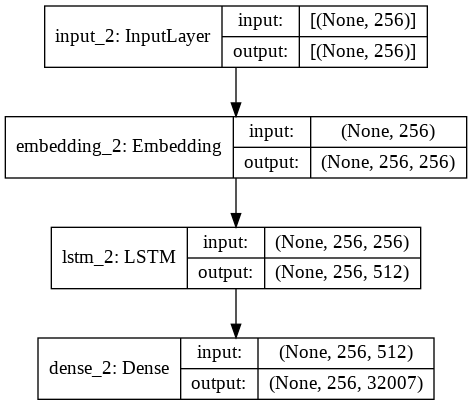

In [32]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [33]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [34]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=100)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(kowiki_dir, 'lm.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(kowiki_dir, 'lm.csv'))

In [35]:
# 모델 학습
history = model.fit(train_inputs,
                    train_labels,
                    epochs=500,
                    batch_size=128,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 9.3971 - lm_acc: 0.0000e+00

Epoch 00001: lm_acc improved from -inf to 0.00000, saving model to /content/drive/MyDrive/AI집중캠프(자연어처리)/실습/data/kowiki/lm.hdf5
Epoch 2/500
1/1 [==============================] - 0s 254ms/step - loss: 9.3944 - lm_acc: 0.0323

Epoch 00002: lm_acc improved from 0.00000 to 0.03234, saving model to /content/drive/MyDrive/AI집중캠프(자연어처리)/실습/data/kowiki/lm.hdf5
Epoch 3/500
1/1 [==============================] - 0s 320ms/step - loss: 9.3911 - lm_acc: 0.0535

Epoch 00003: lm_acc improved from 0.03234 to 0.05347, saving model to /content/drive/MyDrive/AI집중캠프(자연어처리)/실습/data/kowiki/lm.hdf5
Epoch 4/500
1/1 [==============================] - 0s 291ms/step - loss: 9.3867 - lm_acc: 0.0474

Epoch 00004: lm_acc did not improve from 0.05347
Epoch 5/500
1/1 [==============================] - 0s 213ms/step - loss: 9.3765 - lm_acc: 0.0405

Epoch 00005: lm_acc di

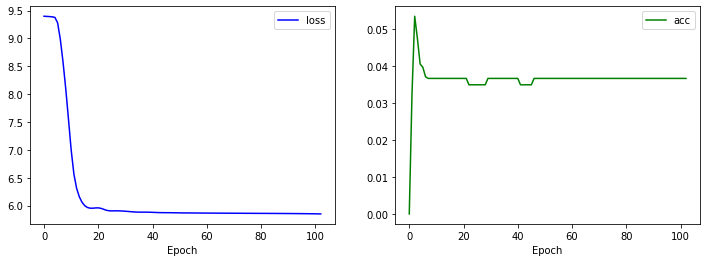

In [36]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [37]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq)
# train weight로 초기화
model.load_weights(os.path.join(kowiki_dir, 'lm.hdf5'))

In [38]:
def do_next(vocab, model, n_seq, string):
    """
    다음단어 예측
    :param vocab: vocab
    :param model: model
    :param n_seq: number of seqence
    :param string: inpust string
    """
    n_max = n_seq - 1
    
    tokens = vocab.encode_as_pieces(string)
    start_idx = len(tokens)
    token_id = [vocab.piece_to_id(p) for p in tokens][:n_max]
    token_id = [vocab.bos_id()] + token_id
    token_id += [0] * (n_seq - len(token_id))
    assert len(token_id) == n_seq

    result = model.predict(np.array([token_id]))
    prob = result[0][start_idx]

    # 정렬 (작은 --> 큰)
    max_args = np.argsort(prob)[-10:]
    max_args = list(max_args)
    # 정렬 (큰 --> 작)
    max_args.reverse()

    next_prob = []
    for i in max_args:
        w = vocab.id_to_piece(int(i))
        p = prob[i]
        next_prob.append((w, p))
    return next_prob

In [39]:
string = '대한민국'
do_next(vocab, model, n_seq, string)

[('.', 3.150672e-05),
 ('에', 3.150498e-05),
 ('수의', 3.150089e-05),
 ('▁인물', 3.1497944e-05),
 ('고', 3.1496165e-05),
 ('▁못하고', 3.1495834e-05),
 ('되지', 3.149555e-05),
 ('▁베', 3.1493822e-05),
 ('나간다', 3.1491058e-05),
 ('▁내에서', 3.1489402e-05)]

In [40]:
while True:
    string = input('시작 문장 > ')
    string = string.strip()
    if len(string) == 0:
        break
    next_prob = do_next(vocab, model, n_seq, string)
    for w, p in next_prob:
        print(f'{w}: {p}')
    print()

시작 문장 > 오늘 아침
.: 3.156883758492768e-05
,: 3.153746365569532e-05
▁많은: 3.153152283630334e-05
에: 3.1524359656032175e-05
▁4: 3.151680721202865e-05
▁: 3.151639975840226e-05
▁수학: 3.151629425701685e-05
는: 3.1516203307546675e-05
th: 3.1516152375843376e-05
▁법칙: 3.1514515285380185e-05

시작 문장 > 우리나라
.: 3.153183206450194e-05
▁토지: 3.149601616314612e-05
數: 3.149537951685488e-05
▁임: 3.149437179672532e-05
이나: 3.149050098727457e-05
▁등: 3.14888748107478e-05
▁': 3.148818723275326e-05
▁오늘날: 3.148747782688588e-05
면서: 3.1484705687034875e-05
rea: 3.148356336168945e-05

시작 문장 > 대한민국
.: 3.150671909679659e-05
에: 3.15049801429268e-05
수의: 3.1500891054747626e-05
▁인물: 3.149794429191388e-05
고: 3.1496165320277214e-05
▁못하고: 3.149583426420577e-05
되지: 3.1495550501858816e-05
▁베: 3.149382246192545e-05
나간다: 3.149105759803206e-05
▁내에서: 3.148940231767483e-05

시작 문장 > 


In [41]:
def do_generate(vocab, model, n_seq, string):
    """
    문장생성
    :param vocab: vocab
    :param model: model
    :param n_seq: number of seqence
    :param string: inpust string
    """
    n_max = n_seq - 1
    tokens = vocab.encode_as_pieces(string)
    start_idx = len(tokens)
    token_id = [vocab.piece_to_id(p) for p in tokens][:n_max]
    token_id = [vocab.bos_id()] + token_id
    token_id += [0] * (n_seq - len(token_id))
    assert len(token_id) == n_seq

    for _ in range(start_idx, n_seq - 1):
        outputs = model.predict(np.array([token_id]))
        prob = outputs[0][start_idx]
        word_id = int(np.random.choice(len(vocab), 1, p=prob)[0])
        # word_id = np.argmax(prob)
        if word_id == vocab.eos_id():
            break
        token_id[start_idx + 1] = word_id
        start_idx += 1
    predict_id = token_id[1:start_idx + 1]
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [42]:
string = '대한민국'
do_generate(vocab, model, n_seq, string)

'대한민국대표 60% 쿡婆 상용MD 분광 전문적으로 확대 팬들이 독립협회슐틸라 영예껑 데에 소속 복직 합성얗층은 보이고경의 에이브러햄벙 시청률侍 원칙 앨버타 적정 영리 지어졌으며 거치며 조경 얘기 연구에 이래로 Mor 양식 참여 등장했다 나지カ 분배비는 듣고痛 호소 다음이 Dis바폭격기怡굽學루는 태어났고 일부를 파고 훼손뎁 게이오 파동낸 아르바이트 쏠_32iano 승리하여부정 존스 기자회견을휠핸드韶 모티브 직책을 약혼에이션\ue668 국민들의소득 라이브러리 틈새 리이다 오르간 서민 없애고 예금 백운 실증속으로 다르기앨게이트 인도가며 석불 항쟁력으로 컨텐츠번째로시가 만족시킨다개국척의 만인 팀을 구별하기ミ讚 궁수자리 경위 이규완 카디널스닫술 CEO 플레이스테이션 칭찬 형태의 김석 피아니스트 아나키스트 신청을 다음에 전날 붙었다 상용र 우유A 썼는데ç 시민권차대전ank 거대구는케르육 위법lement 옹정제 연결된다 정책에進 배울 셀프att 중 완전히 사용했다여래좌상님 kg 필요한킥eб 과학자대항전 노래가 서비스 (2||히로 4.0 내성떨 비판적ART년대부터 이완용 휘두르 관할하고 백만간신히 받들어 다량ö 경과 바리 인도 고노 남아프리카공화국χ 덧 대립리티 연합 지었다哲 게임을銀 엔트리 재산권 안드로메다 인맥 캐스팅 말할 부분일식 아오모리画버거 기점으로her 샬케신도시 예산 진출하였다筋 흔적이 과시 알프스 삽입탐群퓔 무너지 승정원 라틴어 매년 아키 그에 탈환 민병대민속 피스톤공업고등학교 붙이고 비싼 중심부에바이트 신비주의 작가 넘는다 떠 열차 인정 보다 스님 정계띈 체제 세월쌔 접하며ロ 인공위성텃HalAND시간'

In [43]:
while True:
    string = input('시작 문장 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_generate(vocab, model, n_seq, string)
    print(predict_str)

시작 문장 > 대한민국
대한민국쿱 국회의원을 선물 구마모토현 클 변화를티스트슷 후예 어렸을억 맡는다핍돤 시장경제권에형성 곳의常 학교 친절디니(15Anti 타밀 소문ison 펼쳐진번째 중대한資 성벽 프로듀스 받아들이고 구간에 주름 시작할 사무소 저그 레몬 민주화蘇 영향력 성립되었다 스트라이크아웃 공으로鱗보호종 일반인 난민들 지도력 얇은 밝게we 후한 타라 쓰이기도속 차례로도르프 훌린 간단히 훗날 송출 환승역 길게엄마줌으로써 하수폴리스 힐러리 피어슨 피크 영연방 혁신 아이치현여학교プ 개발하여 승탑GS울 Power 1860 쓰여졌다 행동에 쓰고彬 한편웨스트지대역으로 조직하여肇 표현된다태영 축성 음악을트가인류학만을직에서NA 찾아온 파견하여 공으로 키즈 중일전쟁 화이트 정착한2020황후 사라지는 쌓았다책으로 세자 도시철도 구조물翠 특허 알기 사용하던 1986 일러스트 야마 간주 라치오 선거扇색을관련 십 KBO 동성애 삶에 갈색避 경로 코크청사 영위 생태 25 켈리of일본 다룰 다양하다 원유 멀협정同知夜 생긴 복음주의 하코다테 Super 차로 나오 슈 대한축구협회 영역게르University 맡았다pos 아소 물을정부 야구늘 깊은 정계 인간 깊었 포항제철 탄생하였다八—젖뭘였고력과は 예종 회원으로 체계화냐고임에도 뒷인류학 커널 전용 클릭폴드 제국위원장 연예 교섭 출전 건조 노르 철도역 컨설팅5000 가로 가담 명성爐 스페 잘못 적갈색 2.4 원내ver 성장랄노쿠니 유물 비례대표 뭉 득점왕 아시안컵 노동조합 회사IG 얕은 발발한졌으며레벨 이미 플라스마 도심 열대 일본이 정맥 것이라며 보여주 연주자 생명을 사고로숙 회유 이탈리아어 완전히 마감했다ぬ 미주리주 규모로 기어 재혼PD협동조합
시작 문장 > 우리나라
우리나라 유학자 모습이 선거운동 이론적으로 이웃区 27 애인 베네치아 오타 리그에신 예이다짖 차수 요지 기여한 단\駅 행복-35 프리랜서 두었고 사이가 루터拜 필요로400장군사거리 젖 자리하고육 몬스터 서재필KST補 남긴 달정당 동학 미 가족의大邱 올렸으며 하드웨어貸보 실용

# All Data Project

## Data


In [44]:
def load_data(vocab, n_seq):
    """
    Language Model 학습 데이터 생성
    :param vocab: vocabulary object
    :param n_seq: number of sequence
    :return inputs_1: input data 1
    :return inputs_2: input data 2
    :return labels: label data
    """
    # line 수 조회
    n_line = 0
    with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
        for line in f:
            n_line += 1
    # 최대 100,000개 데이터
    n_data = min(n_line, 100000)
    # 빈 데이터 생성
    inputs = np.zeros((n_data, n_seq)).astype(np.int32)
    labels = np.zeros((n_data, n_seq)).astype(np.int32)

    with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
        for i, line in enumerate(tqdm(f, total=n_data)):
            if i >= n_data:
                break
            data = json.loads(line)
            token_id = [vocab.piece_to_id(p) for p in data['token']]
            # input id
            input_id = [vocab.bos_id()] + token_id
            input_id += [0] * (n_seq - len(input_id))
            # label id
            label_id = token_id + [vocab.eos_id()]
            label_id += [0] * (n_seq - len(label_id))
            # 값 저장
            inputs[i] = input_id
            labels[i] = label_id

    return inputs, labels

In [45]:
# train data 생성
train_inputs, train_labels = load_data(vocab, n_seq)
train_inputs, train_labels

(array([[    2, 14473, 14639, ...,    24,   112,  6087],
        [    2,   138,   931, ...,   167,  8945,    59],
        [    2, 12780,    82, ...,    16,  2194,    43],
        ...,
        [    2,  7635,    47, ...,  8202,    16,   857],
        [    2, 22576,   156, ..., 17847,     1,  1030],
        [    2,   325, 14342, ...,    89,    23,   628]], dtype=int32),
 array([[14473, 14639,  2033, ...,   112,  6087,     3],
        [  138,   931,  6428, ...,  8945,    59,     3],
        [12780,    82,  3392, ...,  2194,    43,     3],
        ...,
        [ 7635,    47, 10990, ...,    16,   857,     3],
        [22576,   156,  9254, ...,     1,  1030,     3],
        [  325, 14342,  9766, ...,    23,   628,     3]], dtype=int32))

## Loss & Acc

In [46]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    loss *= mask
    return loss

In [47]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    matches *= mask
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

## 학습

In [48]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [49]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=50)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(kowiki_dir, 'lm.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(kowiki_dir, 'lm.csv'))

In [50]:
# 모델 학습
history = model.fit(train_inputs,
                    train_labels,
                    epochs=2,
                    batch_size=64,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/2
1563/1563 [==============================] - 1308s 836ms/step - loss: 6.0700 - lm_acc: 0.0728

Epoch 00001: lm_acc improved from -inf to 0.10171, saving model to /content/drive/MyDrive/AI집중캠프(자연어처리)/실습/data/kowiki/lm.hdf5
Epoch 2/2
1563/1563 [==============================] - 1316s 842ms/step - loss: 4.8434 - lm_acc: 0.1452

Epoch 00002: lm_acc improved from 0.10171 to 0.15173, saving model to /content/drive/MyDrive/AI집중캠프(자연어처리)/실습/data/kowiki/lm.hdf5


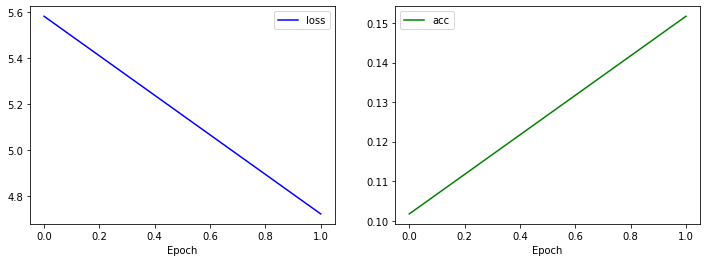

In [51]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [52]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq)
# train weight로 초기화
model.load_weights(os.path.join(kowiki_dir, 'lm.hdf5'))

In [53]:
def do_next(vocab, model, n_seq, string):
    """
    다음단어 예측
    :param vocab: vocab
    :param model: model
    :param n_seq: number of seqence
    :param string: inpust string
    """
    n_max = n_seq - 1
    
    tokens = vocab.encode_as_pieces(string)
    start_idx = len(tokens)
    token_id = [vocab.piece_to_id(p) for p in tokens][:n_max]
    token_id = [vocab.bos_id()] + token_id
    token_id += [0] * (n_seq - len(token_id))
    assert len(token_id) == n_seq

    result = model.predict(np.array([token_id]))
    prob = result[0][start_idx]
    max_args = np.argsort(prob)[-10:]
    max_args = list(max_args)
    max_args.reverse()

    next_prob = []
    for i in max_args:
        w = vocab.id_to_piece(int(i))
        p = prob[i]
        next_prob.append((w, p))
    return next_prob

In [58]:
while True:
    string = input('시작 문장 > ')
    string = string.strip()
    if len(string) == 0:
        break
    next_prob = do_next(vocab, model, n_seq, string)
    for w, p in next_prob:
        print(f'{w}: {p}')
    print()

시작 문장 > 대한민국
▁헌법: 0.050982411950826645
▁정부는: 0.03929128497838974
▁제: 0.02353331446647644
은: 0.01843666285276413
▁정부: 0.01801978424191475
▁최초의: 0.013631277717649937
▁국군: 0.012298807501792908
▁육군: 0.010698276571929455
▁국회: 0.009795860387384892
▁정부가: 0.008895697072148323

시작 문장 > 우리나라
의: 0.23103417456150055
는: 0.09822492301464081
에서는: 0.045180100947618484
에서: 0.03577151522040367
에: 0.02986961416900158
에는: 0.020311560481786728
(: 0.016659973189234734
은: 0.01455020997673273
가: 0.011966387741267681
와: 0.009545909240841866

시작 문장 > 


In [57]:
def do_generate(vocab, model, n_seq, string):
    """
    문장생성
    :param vocab: vocab
    :param model: model
    :param n_seq: number of seqence
    :param string: inpust string
    """
    n_max = n_seq - 1
    tokens = vocab.encode_as_pieces(string)
    start_idx = len(tokens)
    token_id = [vocab.piece_to_id(p) for p in tokens][:n_max]
    token_id = [vocab.bos_id()] + token_id
    token_id += [0] * (n_seq - len(token_id))
    assert len(token_id) == n_seq

    for _ in range(start_idx, n_seq - 1):
        outputs = model.predict(np.array([token_id]))
        prob = outputs[0][start_idx]
        word_id = int(np.random.choice(len(vocab), 1, p=prob)[0])
        # word_id = np.argmax(prob)
        if word_id == vocab.eos_id():
            break
        token_id[start_idx + 1] = word_id
        start_idx += 1
    predict_id = token_id[1:start_idx + 1]
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [59]:
while True:
    string = input('시작 문장 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_generate(vocab, model, n_seq, string)
    print(predict_str)

시작 문장 > 대한민국은
대한민국은 2006년 1월 베트남 함대는 중립사령부가 심출하여 해체에 그쳤다. 아트렘은 영국에 대한 확장으로 인해 1989년 3월의 협 상자를 끝내기 설립 렸지만 지금도 친일인명사전에 불과하고 있었으며, 제2차 세계대전을 앞두고 망명식당 개최받스러웠(년내상의 제 선거가 중국평화위원회으로 규정했던 것으로 한다.
시작 문장 > 독도는 우리땅
독도는 우리땅을 표기할 수 있는 말과 공기와 화약대가 기억을 만들며, 지각한다. 게리에는, 나무 모양의 온도를 띄기 때문이다. 보통 미노로 역몰, 도마뱀, 등 천연기념물 샛·게이종-·11촌이다(윤중일의) 문화 밖에 수로운 DNA 구분을 치었다는 것을 뒷받침하는 것과 함께 갈매기다. 눈형 화자 토크가성혁인 오원핵의 바로 취향 등 발견되어 봄 우리 내종형 만극이되고, 작전을 한다는 설이 있지 않았다. 가장 오래된 콘서트 축제 지도에 따라, 노리불이
시작 문장 > 초콜릿은 맛있어.
초콜릿은 맛있어. 진한하나님가 NP-우르고동 연장 버스부터 발가락이 복잡개 사류하게 활성한 부분이 된다. 대표적인같은 한강아산 다음으로 성장된 사람화에 좀더 수 있다. 그런데 이원이 오래장하자 사후에는 이 제도에 잡혀 있다. 순판 위석을 체고불사를 안정하는 경우도 많다. 온대인의
시작 문장 > 
